# Hotel


### Problema
En la competencia de Kaggle se presenta un problema para combatir la trata de personas. Identificar la ubicación de una habitación de hotel es un problema desafiante de gran interés para combatir la trata de personas. 

Por lo que en el reto se nos presenta un total de 3116 clases que pertenecen a diferentes cadenas de hoteles. Para cada una de ellas se cuenta con fotografías de la habitación.

### Importar librerías

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras import models
from keras import optimizers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from random import sample
from shutil import move
from random import sample
from shutil import copy
from keras.applications.efficientnet import EfficientNetB3
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input

In [ ]:
base_dir = 'hotel-id-to-combat-human-trafficking-2022-fgvc9'
train_dir = os.path.join(base_dir,'train_images')
directory_list = os.listdir(train_dir)
save_directory = os.path.join(base_dir,'processed_images3')

### Análisis de los datos 

Lo primero que podemos hacer es analizar la cantidad de imágenes que tenemos por clase, para ver si falta balanceo de datos. 

840
16
[14.34627728]


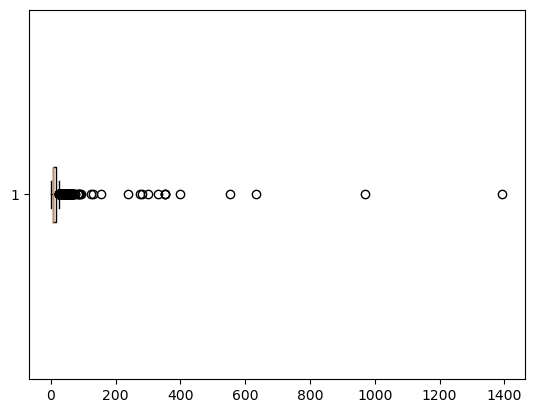

In [ ]:
directory_list = os.listdir(train_dir)
len_directory_list = len(directory_list)
classes = np.empty((len_directory_list,1))
total_max = 0
total_min = 0
mean = 0
n_max = 100
n_min = 14

for i, dir in enumerate(directory_list):
    temp_dir = os.path.join(train_dir, dir)
    classes[i] = len(os.listdir(temp_dir))
    mean += classes[i]
    if classes[i] < n_min:
        total_min += 1
    if classes[i] >= n_max:
        total_max += 1

mean /= len_directory_list
plt.boxplot(classes, vert = False)
print(total_max)
print(mean)

Como se puede observar existe una gran disparidad en el número de imágenes por clase. Existen clases con 1 sola imagen y 1 con más de 1400. De igual manera podemos ver que la media de imágenes por clase es de 14; y que la mayoría de las clases tienen menos de 200 imágenes.  

### Data Augmentation

Para el aumento de datos se usó de la librería de keras el ImageDataGenerator.

In [ ]:
IMG_SIZE = 256

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   cval = 0)


In [ ]:
# Función para guardar una imagen
def save_image(img_path, i, save_dir): 
    name = os.path.join(save_dir, str(i) + '.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path).resize((IMG_SIZE, IMG_SIZE))
    img.save(name)

Creamos una función para el balanceo de datos. Esta función hace oversampling y undersampling.

Recibe los siguientes parámetros:
*  **Min_img**: El número mínimo de imágenes que debe contener una clase para ser considerada dentro del conjunto de datos de entrenamiento. No nos sirve quedarnos con las clases que tienen muy pocas imágenes, por lo que si una clase tiene menos de este número se eliminará y no será usada para el entrenamiento.
*  **Times_target_number**: Para obtener el target number de imágenes que habrá en cada clase (oversampling) se multiplica el número de imágenes mínimas por este valor. 
*  **Max_target**: El número máximo de imágenes que debe contener una clase. De esta manera podemos hacer undersampling a clases que tengan demasiadas imágenes. Si no pasamos un valor para este parámetro se usará por default None, lo que querrá decir que no se realizará undersampling.

Con esta función podemos hacer un balanceo de datos, así como solo realizar oversampling ya que queríamos probar si el undersampling realmente nos ayudaría.

In [ ]:
def data_balancing(min_img, times_target_number, max_target=None):
  
  target_number = min_img * times_target_number
  directory_list = os.listdir(train_dir)

  # Create save and test directories
  if not os.path.exists(save_directory):
    os.mkdir(save_directory)

  # Iterate Kaggle Dataset
  for dir in directory_list:
    temp_train_dir = os.path.join(train_dir, dir)
    # Skip classes with less images than our minimum number required
    if len(os.listdir(temp_train_dir)) < min_img:
      continue
    
    # Create save and test class folders
    temp_save_dir = os.path.join(save_directory, dir)
    if not os.path.exists(temp_save_dir):
      os.mkdir(temp_save_dir)

    # List all image paths from class
    img_names = [os.path.join(temp_train_dir, name) for name in os.listdir(temp_train_dir)]
    len_img = len(img_names)
    len_temp_dir = len(os.listdir(temp_save_dir))

    # Oversampling
    if len_img < target_number and len_temp_dir < target_number:
      # Determine number of images generated from each image
      remainder = sample(img_names, k= target_number % len(img_names)) 
      target_per_img = target_number // len(img_names) - 1
      i, j = 0, 0

      for img_path in img_names:
        save_image(img_path, i, temp_save_dir)
        i += 1
        
        if target_per_img > 0 or img_path in remainder:
          img = tf.keras.preprocessing.image.load_img(img_path).resize((IMG_SIZE, IMG_SIZE))
          img_array = tf.keras.preprocessing.image.img_to_array(img)
          img_array = img_array.reshape((1,) + img_array.shape)

          for batch in train_datagen.flow(img_array, batch_size=1):
            temp = tf.keras.preprocessing.image.array_to_img(batch[0])
            name = os.path.join(temp_save_dir, str(i) + '.jpg')
            temp.save(name)
            i += 1
            j += 1

            if (img_path in remainder and j == (target_per_img + 1)) or \
              (img_path not in remainder and j == target_per_img):
                j = 0
                break

    # Undersampling
    elif len_img >= target_number and len_temp_dir < len_img:
      if max_target is None:
        for i, img_path in enumerate(img_names):
          save_image(img_path, i, temp_save_dir)
      else:
        target = 0
        if max_target < len_img:
          target = max_target
        else:
          target = len_img
        random_images = sample(img_names, k= target)
        for i, img_path in enumerate(random_images):
            save_image(img_path, i, temp_save_dir)


### Diferentes Balanceos de Clases

Se corrió el balanceo de datos con diferentes configuraciones para probar. Estas se guardaron en diferentes carpetas de datos procesados:

*  **processed_images**: En esta carpeta se hizo un balanceo de datos. Se usó oversampling y undersampling para que las 3116 clases tuvieran todas 15 imágenes.
*  **processed_images3**: En esta carpeta se usó oversampling únicamente. Las 3116 clases tuvieran 15 imágenes como mínimo, pero en caso de tener más se dejan todas las imágenes.
*  **processed_images4**: En esta carpeta se quitaron las clases que tuvieran menos de 14 imágenes, lo que nos deja con un total de 840 clases. Se usó oversampling para que cada clase tuviera 112 imágenes y un máximo de 400 imágenes.
*  **processed_images20**: En esta carpeta se quitaron las clases que tuvieran menos de 20 imágenes, lo que nos deja con un total de 505 clases. Se usó oversampling para que cada clase tuviera 160 imágenes y un máximo de 400 imágenes.
*  **processed_imagesOversampling20**: En esta carpeta se quitaron las clases que tuvieran menos de 20 imágenes, lo que nos deja con un total de 505 clases. Se usó oversampling para que cada clase tuviera 160 imágenes pero a diferencia del anterior directorio, no se hace undersampling y todas las clases mayores a 160 se quedan con su cantidad original

In [ ]:
# Ejemplo para crear el directorio de processed_imagesOversampling20
min_img = 1
times_target_number = 15
max_target = 400

data_balancing(min_img, times_target_number)

## Balanceo de Datos y EfficientNet

Se probó primero con un balanceo de datos para que todas las clases tuvieran las mismas fotos.

**Separación entre train y validation**

In [ ]:
save_directory = os.path.join(base_dir,'processed_images')

train_data = ImageDataGenerator(validation_split=0.2)
train_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (256, 256),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='training')

valid_generator = train_data.flow_from_directory(save_directory, 
                                                    target_size = (256, 256),
                                                    batch_size=20,
                                                    class_mode="categorical",
                                                 subset='validation')


Found 37392 images belonging to 3116 classes.
Found 9348 images belonging to 3116 classes.


**EfficientNetB3**
El primer modelo con el que probamos fue con VGG16, y después de una investigación obtuvimos mejores reultados con EfficientNetB3, sin incluir la capa final. Como se puede observar este modelo tiene demasiados parámetros.

In [ ]:
conv_base = EfficientNetB3(weights='imagenet',
                          include_top=False,
                          input_shape=(256, 256, 3))
conv_base.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0

In [ ]:
modelBalanceo = models.Sequential([
                           conv_base,
                           Flatten(),
                           Dense(256, activation='relu'),
                           Dense(3116, activation='softmax')                    
                          ])

modelBalanceo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 8, 8, 1536)       10783535  
                                                                 
 flatten (Flatten)           (None, 98304)             0         
                                                                 
 dense (Dense)               (None, 256)               25166080  
                                                                 
 dense_1 (Dense)             (None, 3116)              800812    
                                                                 
Total params: 36,750,427
Trainable params: 36,663,124
Non-trainable params: 87,303
_________________________________________________________________


In [ ]:
conv_base.trainable = False
modelBalanceo.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

Algo importante a destacar es que usamos como métrica no solo el **Accuracy** sino también el **Top K Categorical Accuracy** el cual toma el top 5 de predicciones y si esta la correcta dentro de las 5 más probables da un mejor accuracy. Esto sirve debido a que la forma de evaluar la competencia en Kaggle es algo similar a esto. 

In [ ]:
historyBalanceo = modelBalanceo.fit(train_generator, epochs=6, validation_data=valid_generator)

Epoch 1/6
293/293 [==============================] - 2037s 7s/step - loss: 8.0791 - acc: 9.3603e-04 - top_k_categorical_accuracy: 0.0017 - val_loss: 8.0514 - val_acc: 0.0019 - val_top_k_categorical_accuracy: 0.0035
Epoch 2/6
293/293 [==============================] - 1935s 7s/step - loss: 7.9962 - acc: 0.0060 - top_k_categorical_accuracy: 0.0110 - val_loss: 8.0895 - val_acc: 0.0025 - val_top_k_categorical_accuracy: 0.0047
Epoch 3/6
293/293 [==============================] - 3405s 12s/step - loss: 7.8842 - acc: 0.0128 - top_k_categorical_accuracy: 0.0224 - val_loss: 8.0978 - val_acc: 0.0028 - val_top_k_categorical_accuracy: 0.0056
Epoch 4/6
293/293 [==============================] - 4014s 14s/step - loss: 7.8033 - acc: 0.0188 - top_k_categorical_accuracy: 0.0325 - val_loss: 8.1183 - val_acc: 0.0027 - val_top_k_categorical_accuracy: 0.0055
Epoch 5/6
293/293 [==============================] - 1767s 6s/step - loss: 7.7432 - acc: 0.0225 - top_k_categorical_accuracy: 0.0383 - val_loss: 8.120

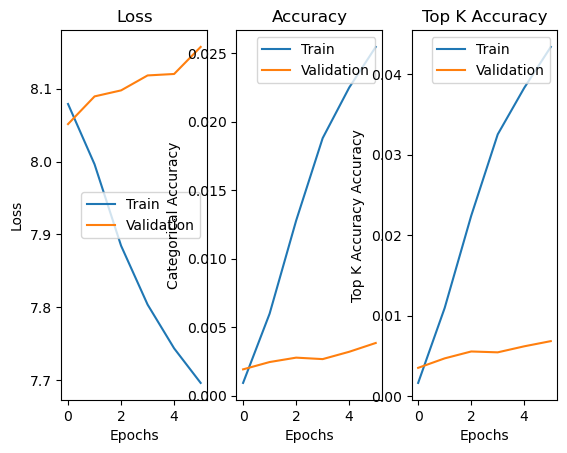

In [ ]:
plt.subplot(1, 3, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(historyBalanceo.history["loss"], label="Train")
plt.plot(historyBalanceo.history["val_loss"], label="Validation")
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.plot(historyBalanceo.history["acc"], label="Train")
plt.plot(historyBalanceo.history["val_acc"], label="Validation")
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Top K Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Top K Accuracy Accuracy")
plt.plot(historyBalanceo.history["top_k_categorical_accuracy"], label="Train")
plt.plot(historyBalanceo.history["val_top_k_categorical_accuracy"], label="Validation")
plt.legend()

Como se puede observar con balanceo de clases solamente llegamos a un 6.8% en validación.

## Solo usando Oversampling y EfficientNet

Se probó después haciendo Oversampling, pero sin hacer undersampling entonces las clases con más de 15 imágenes si se quedarían con todas sus imágenes..

**Separación entre train y validation**

In [ ]:
save_directory = os.path.join(base_dir,'processed_images3')

train_data = ImageDataGenerator(validation_split=0.2)
train_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (256, 256),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='training')

valid_generator = train_data.flow_from_directory(save_directory, 
                                                    target_size = (256, 256),
                                                    batch_size=20,
                                                    class_mode="categorical",
                                                 subset='validation')


Found 49228 images belonging to 3116 classes.
Found 11980 images belonging to 3116 classes.


In [ ]:
conv_base = EfficientNetB3(weights='imagenet',
                          include_top=False,
                          input_shape=(256, 256, 3))
conv_base.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [ ]:
modelOversampling = models.Sequential([
                           conv_base,
                           Flatten(),
                           Dense(256, activation='relu'),
                           Dense(3116, activation='softmax')                    
                          ])

modelOversampling.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 8, 8, 1536)       10783535  
                                                                 
 flatten_1 (Flatten)         (None, 98304)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               25166080  
                                                                 
 dense_3 (Dense)             (None, 3116)              800812    
                                                                 
Total params: 36,750,427
Trainable params: 36,663,124
Non-trainable params: 87,303
_________________________________________________________________


In [ ]:
conv_base.trainable = False
modelOversampling.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

In [ ]:
historyOversampling = modelOversampling.fit(train_generator, epochs=6, validation_data=valid_generator)

Epoch 1/6
385/385 [==============================] - 445s 1s/step - loss: 7.5061 - acc: 0.0736 - top_k_categorical_accuracy: 0.0967 - val_loss: 7.2881 - val_acc: 0.0873 - val_top_k_categorical_accuracy: 0.1085
Epoch 2/6
385/385 [==============================] - 228s 591ms/step - loss: 7.1041 - acc: 0.0947 - top_k_categorical_accuracy: 0.1173 - val_loss: 7.2655 - val_acc: 0.0982 - val_top_k_categorical_accuracy: 0.1158
Epoch 3/6
385/385 [==============================] - 233s 604ms/step - loss: 6.8194 - acc: 0.1066 - top_k_categorical_accuracy: 0.1344 - val_loss: 7.2185 - val_acc: 0.0996 - val_top_k_categorical_accuracy: 0.1168
Epoch 4/6
385/385 [==============================] - 217s 564ms/step - loss: 6.6017 - acc: 0.1153 - top_k_categorical_accuracy: 0.1501 - val_loss: 7.2937 - val_acc: 0.1018 - val_top_k_categorical_accuracy: 0.1215
Epoch 5/6
385/385 [==============================] - 224s 582ms/step - loss: 6.4285 - acc: 0.1221 - top_k_categorical_accuracy: 0.1615 - val_loss: 7.38

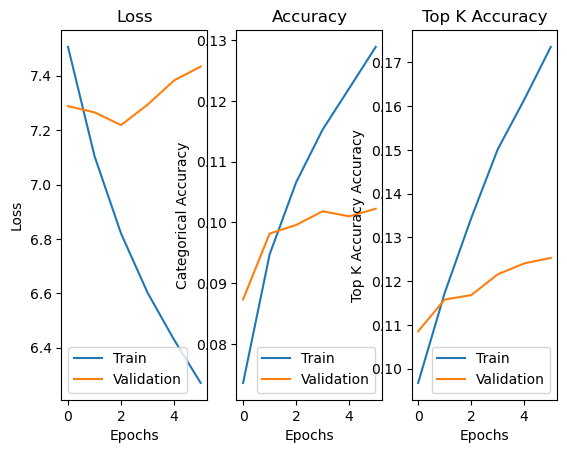

In [ ]:
plt.subplot(1, 3, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(historyOversampling.history["loss"], label="Train")
plt.plot(historyOversampling.history["val_loss"], label="Validation")
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.plot(historyOversampling.history["acc"], label="Train")
plt.plot(historyOversampling.history["val_acc"], label="Validation")
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Top K Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Top K Accuracy Accuracy")
plt.plot(historyOversampling.history["top_k_categorical_accuracy"], label="Train")
plt.plot(historyOversampling.history["val_top_k_categorical_accuracy"], label="Validation")
plt.legend()

Como se puede observar sin hacer undersampling obtuvimos un accuracy de 12.53% en la epoch 6, con lo que podemos observar que se tienen mejores resultados sin usar undersampling.


## Mínimo 14 imágenes por clase

Se probó quitando las clases que tuvieran menos de 14 imágenes (la media), haciendo oversampling para tener 112 imágenes por clase y máximo 400.

**Separación entre train y validation**

In [ ]:
save_directory = os.path.join(base_dir,'processed_images4')

train_data = ImageDataGenerator(validation_split=0.2)
train_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (256, 256),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='training')

valid_generator = train_data.flow_from_directory(save_directory, 
                                                    target_size = (256, 256),
                                                    batch_size=20,
                                                    class_mode="categorical",
                                                 subset='validation')


Found 78078 images belonging to 840 classes.
Found 19102 images belonging to 840 classes.


**EfficientNetB3**
El primer modelo con el que probamos fue con EfficientNetB3, sin incluir la capa final. Como se puede observar este modelo tiene demasiados parámaetros.

In [ ]:
conv_base = EfficientNetB3(weights='imagenet',
                          include_top=False,
                          input_shape=(256, 256, 3))
conv_base.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 256, 256, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                     

In [ ]:
model = models.Sequential([
                           conv_base,
                           Flatten(),
                           Dense(256, activation='relu'),
                           Dense(840, activation='softmax')                    
                          ])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 8, 8, 1536)       10783535  
                                                                 
 flatten_4 (Flatten)         (None, 98304)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               25166080  
                                                                 
 dense_9 (Dense)             (None, 840)               215880    
                                                                 
Total params: 36,165,495
Trainable params: 36,078,192
Non-trainable params: 87,303
_________________________________________________________________


In [ ]:
conv_base.trainable = False
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

In [ ]:
history = model.fit(train_generator, epochs=6, validation_data=valid_generator)

Epoch 1/6
610/610 [==============================] - 366s 584ms/step - loss: 6.7149 - acc: 0.0113 - top_k_categorical_accuracy: 0.0264 - val_loss: 6.6538 - val_acc: 0.0123 - val_top_k_categorical_accuracy: 0.0299
Epoch 2/6
610/610 [==============================] - 333s 546ms/step - loss: 6.5467 - acc: 0.0212 - top_k_categorical_accuracy: 0.0460 - val_loss: 6.6294 - val_acc: 0.0160 - val_top_k_categorical_accuracy: 0.0395
Epoch 3/6
610/610 [==============================] - 329s 539ms/step - loss: 6.4591 - acc: 0.0287 - top_k_categorical_accuracy: 0.0572 - val_loss: 6.6105 - val_acc: 0.0200 - val_top_k_categorical_accuracy: 0.0402
Epoch 4/6
610/610 [==============================] - 328s 537ms/step - loss: 6.4049 - acc: 0.0329 - top_k_categorical_accuracy: 0.0645 - val_loss: 6.7203 - val_acc: 0.0214 - val_top_k_categorical_accuracy: 0.0427
Epoch 5/6
610/610 [==============================] - 328s 537ms/step - loss: 6.3593 - acc: 0.0374 - top_k_categorical_accuracy: 0.0701 - val_loss: 6

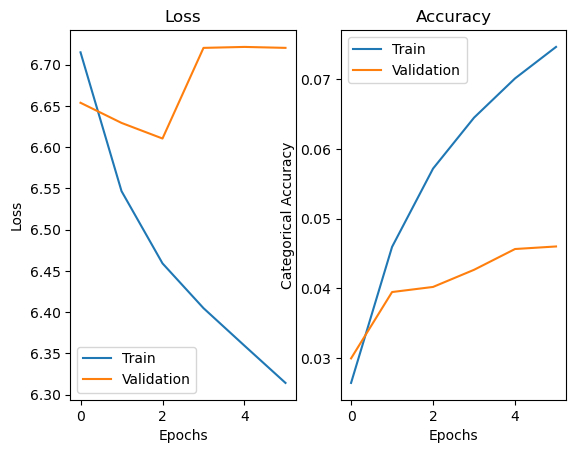

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.plot(history.history["top_k_categorical_accuracy"], label="Train")
plt.plot(history.history["val_top_k_categorical_accuracy"], label="Validation")
plt.legend()

Con 6 epochs logramos llegar al 4.6% de top K Accuracy en validation; este no es un buen resultado. De igual manera como podemos ver la pérdida en validation va aumentando, por lo que no es el mejor modelo.

## Resnet50V2
Usando **Transfer Learning** probamos con los modelos pre entrenados de EfficientNet, VGG16, Resnet50V2 e InceptionV3 mantieniendo congelados sus parámetros con la finalidad de que no sean modificados durante el entrenamiento. El modelo con el que obtivimos mejores resultados fue con Resnet50V2. Se muestra el resultado para las clases con al menos 14 imágenes a continuación.

In [ ]:
IMG_SIZE = 256
train_data = ImageDataGenerator(rescale=1/255,
                                samplewise_center=True,
                                validation_split=0.2)
train_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='training')

valid_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='validation')


Found 87631 images belonging to 840 classes.
Found 9549 images belonging to 840 classes.


In [ ]:
conv_base = ResNet50V2(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
conv_base.trainable = False
model = models.Sequential([
                           conv_base,
                           Flatten(),
                           Dense(256, activation='relu'),
                           Dense(840, activation='softmax')                    
                          ])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

In [ ]:
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=6, validation_data=valid_generator, validation_steps=len(valid_generator))

Epoch 1/6
685/685 [==============================] - 457s 636ms/step - loss: 6.7162 - acc: 0.0118 - top_k_categorical_accuracy: 0.0285 - val_loss: 6.5884 - val_acc: 0.0161 - val_top_k_categorical_accuracy: 0.0347
Epoch 2/6
685/685 [==============================] - 292s 426ms/step - loss: 6.5629 - acc: 0.0178 - top_k_categorical_accuracy: 0.0392 - val_loss: 6.5725 - val_acc: 0.0203 - val_top_k_categorical_accuracy: 0.0374
Epoch 3/6
685/685 [==============================] - 283s 413ms/step - loss: 6.5217 - acc: 0.0234 - top_k_categorical_accuracy: 0.0441 - val_loss: 6.5683 - val_acc: 0.0202 - val_top_k_categorical_accuracy: 0.0389
Epoch 4/6
685/685 [==============================] - 301s 440ms/step - loss: 6.5074 - acc: 0.0250 - top_k_categorical_accuracy: 0.0458 - val_loss: 6.6007 - val_acc: 0.0230 - val_top_k_categorical_accuracy: 0.0394
Epoch 5/6
685/685 [==============================] - 309s 450ms/step - loss: 6.4921 - acc: 0.0264 - top_k_categorical_accuracy: 0.0463 - val_loss: 6

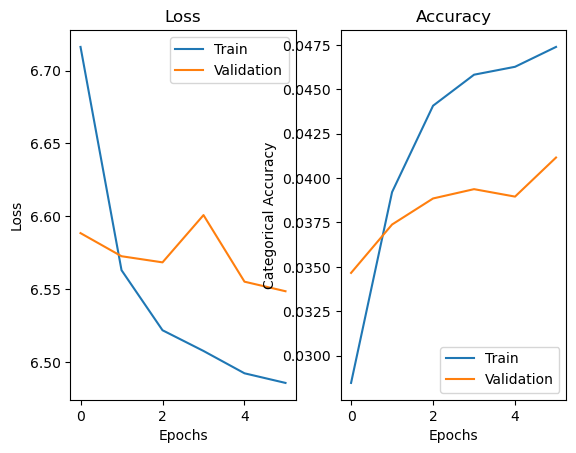

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.plot(history.history["top_k_categorical_accuracy"], label="Train")
plt.plot(history.history["val_top_k_categorical_accuracy"], label="Validation")
plt.legend()

In [ ]:
model.save('modelResnet14.h5')

Como se puede observar después de 6 epochs igual que al usar EfficientNet obtenemos un top k accuracy de 4.12%; esto es un poco menos a lo obtenido con EfficientNet; sin embargo el Loss disminuyé cada vez más con Resnet a diferencia del otro modelo. Y otro beneficio es que Resnet tiene muchos menos parámetros, por lo que el entrenamiento es más rápido.

## Aumentar el número de neuronas en la Capa Densa

Lo siguiente que hicimos para buscar tener mejores resultados, fue aumentar el número de neuronas en la capa densa. Lo más que pudimos aumnetar por el recurso de las computadoas fue a 2048 en la capa densa. 

In [ ]:
IMG_SIZE = 256
train_data = ImageDataGenerator(rescale=1/255,
                                samplewise_center=True,
                                validation_split=0.2)
train_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='training')

valid_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='validation')


Found 78078 images belonging to 840 classes.
Found 19102 images belonging to 840 classes.


In [ ]:
conv_base = ResNet50V2(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
conv_base.trainable = False
model3 = models.Sequential([
                           conv_base,
                           Flatten(),
                           Dense(2048, activation='relu'),
                           Dense(840, activation='softmax')                    
                          ])

In [ ]:
model3.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

In [ ]:
history3 = model3.fit(train_generator, steps_per_epoch=len(train_generator), epochs=6, validation_data=valid_generator, validation_steps=len(valid_generator))

Epoch 1/6
610/610 [==============================] - 366s 589ms/step - loss: 7.3990 - acc: 0.0207 - top_k_categorical_accuracy: 0.0372 - val_loss: 6.5593 - val_acc: 0.0277 - val_top_k_categorical_accuracy: 0.0414
Epoch 2/6
610/610 [==============================] - 363s 595ms/step - loss: 6.4328 - acc: 0.0423 - top_k_categorical_accuracy: 0.0668 - val_loss: 6.5554 - val_acc: 0.0346 - val_top_k_categorical_accuracy: 0.0511
Epoch 3/6
610/610 [==============================] - 347s 568ms/step - loss: 6.2742 - acc: 0.0580 - top_k_categorical_accuracy: 0.0961 - val_loss: 6.6096 - val_acc: 0.0349 - val_top_k_categorical_accuracy: 0.0500
Epoch 4/6
610/610 [==============================] - 351s 575ms/step - loss: 6.1925 - acc: 0.0665 - top_k_categorical_accuracy: 0.1104 - val_loss: 6.5757 - val_acc: 0.0366 - val_top_k_categorical_accuracy: 0.0527
Epoch 5/6
610/610 [==============================] - 350s 574ms/step - loss: 6.1037 - acc: 0.0738 - top_k_categorical_accuracy: 0.1162 - val_loss: 6

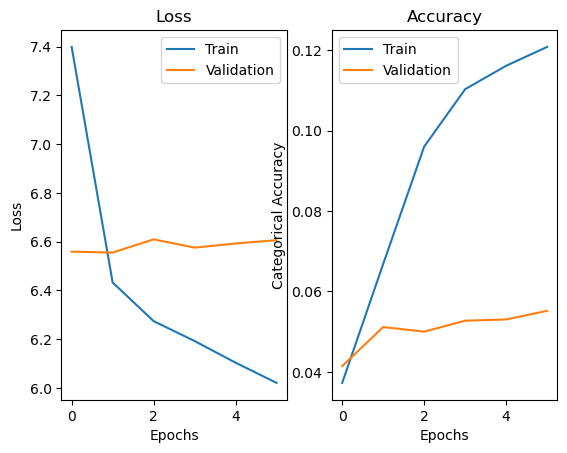

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history3.history["loss"], label="Train")
plt.plot(history3.history["val_loss"], label="Validation")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.plot(history3.history["top_k_categorical_accuracy"], label="Train")
plt.plot(history3.history["val_top_k_categorical_accuracy"], label="Validation")
plt.legend()

Como se puede observar en el mismo número de epochs con 2048 neuronas en la capa densa obtuvimos un accuracy de 5.5%; por lo que esto si nos dio un mejor resultado.

## Clases con al menos 20 imágenes

Se probó quitando las clases que tuvieran menos de 20 imágenes, haciendo oversampling para tener 160 imágenes por clase y haciendo undersampling para tener máximo 400.

In [ ]:
save_directory = os.path.join(base_dir,'processed_images20')
IMG_SIZE = 256
train_data = ImageDataGenerator(rescale=1/255,
                                # featurewise_center=True,
                                samplewise_center=True,
                                validation_split=0.2)
# train_data.fit(X)
train_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='training')

valid_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='validation')


Found 66566 images belonging to 505 classes.
Found 16637 images belonging to 505 classes.


In [ ]:
conv_base = ResNet50V2(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
conv_base.trainable = False
model5 = models.Sequential([
                           conv_base,
                           Flatten(),
                           Dense(2048, activation='relu'),
                           Dense(505, activation='softmax')                    
                          ])

In [ ]:
model5.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

In [ ]:
history5 = model5.fit(train_generator, steps_per_epoch=len(train_generator), epochs=15, validation_data=valid_generator, validation_steps=len(valid_generator))

Epoch 1/15
521/521 [==============================] - 567s 1s/step - loss: 6.9303 - acc: 0.0328 - top_k_categorical_accuracy: 0.0551 - val_loss: 5.9840 - val_acc: 0.0410 - val_top_k_categorical_accuracy: 0.0653
Epoch 2/15
521/521 [==============================] - 269s 516ms/step - loss: 5.7649 - acc: 0.0641 - top_k_categorical_accuracy: 0.1059 - val_loss: 6.0377 - val_acc: 0.0478 - val_top_k_categorical_accuracy: 0.0738
Epoch 3/15
521/521 [==============================] - 269s 516ms/step - loss: 5.4905 - acc: 0.0881 - top_k_categorical_accuracy: 0.1526 - val_loss: 6.0580 - val_acc: 0.0540 - val_top_k_categorical_accuracy: 0.0838
Epoch 4/15
521/521 [==============================] - 269s 515ms/step - loss: 5.2457 - acc: 0.1101 - top_k_categorical_accuracy: 0.1909 - val_loss: 6.0478 - val_acc: 0.0555 - val_top_k_categorical_accuracy: 0.0888
Epoch 5/15
521/521 [==============================] - 270s 518ms/step - loss: 5.0314 - acc: 0.1287 - top_k_categorical_accuracy: 0.2171 - val_loss:

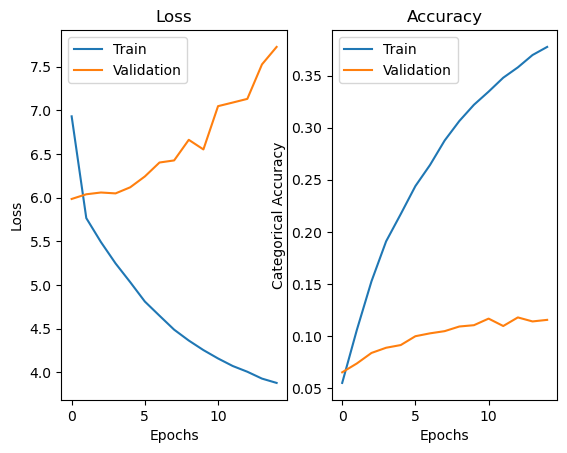

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history5.history["loss"], label="Train")
plt.plot(history5.history["val_loss"], label="Validation")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.plot(history5.history["top_k_categorical_accuracy"], label="Train")
plt.plot(history5.history["val_top_k_categorical_accuracy"], label="Validation")
plt.legend()

In [ ]:
model5.save('modelResnet20imgs.h5')

Como se puede observar después de 15 epochs obtuvimos un top k accuracy de 11.56%; con esto tuvimos mejores resultados sin embargo, aún sigue siendo muy bajo.

### Clases con al menos 20 imágenes sin hacer Undersampling

Para probar si el undersampling estaba afectando los resultados, probamos con la misma arquitectura pero sin hacer undersampling a 400 imágenenes. 

In [ ]:
save_directory = os.path.join(base_dir,'processed_imagesOversampling20')

In [ ]:
IMG_SIZE = 256
train_data = ImageDataGenerator(rescale=1/255,
                                samplewise_center=True,
                                validation_split=0.2)
# train_data.fit(X)
train_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='training')

valid_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='validation')

conv_base = ResNet50V2(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.summary()

conv_base.trainable = False
model6 = models.Sequential([
                           conv_base,
                           Flatten(),
                           Dense(2048, activation='relu'),
                           Dense(505, activation='softmax')                    
                          ])
                          

Found 68125 images belonging to 505 classes.
Found 17025 images belonging to 505 classes.
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 

In [ ]:
model6.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

In [ ]:
history6 = model6.fit(train_generator, steps_per_epoch=len(train_generator), epochs=30, validation_data=valid_generator, validation_steps=len(valid_generator))

Epoch 1/30
533/533 [==============================] - 300s 545ms/step - loss: 8.1370 - acc: 0.0523 - top_k_categorical_accuracy: 0.0783 - val_loss: 5.8449 - val_acc: 0.0667 - val_top_k_categorical_accuracy: 0.0930
Epoch 2/30
533/533 [==============================] - 285s 534ms/step - loss: 5.4860 - acc: 0.0937 - top_k_categorical_accuracy: 0.1490 - val_loss: 5.8213 - val_acc: 0.0801 - val_top_k_categorical_accuracy: 0.1202
Epoch 3/30
533/533 [==============================] - 282s 529ms/step - loss: 4.8541 - acc: 0.1488 - top_k_categorical_accuracy: 0.2507 - val_loss: 5.9299 - val_acc: 0.0900 - val_top_k_categorical_accuracy: 0.1447
Epoch 4/30
533/533 [==============================] - 282s 529ms/step - loss: 4.1463 - acc: 0.2222 - top_k_categorical_accuracy: 0.3732 - val_loss: 6.1172 - val_acc: 0.0996 - val_top_k_categorical_accuracy: 0.1627
Epoch 5/30
533/533 [==============================] - 279s 523ms/step - loss: 3.4825 - acc: 0.3033 - top_k_categorical_accuracy: 0.4860 - val_lo

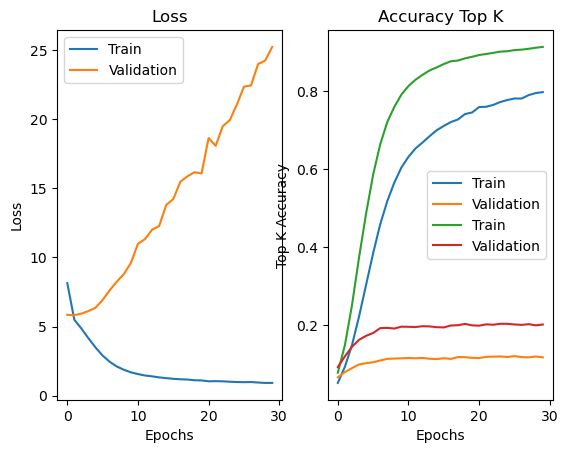

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history6.history["loss"], label="Train")
plt.plot(history6.history["val_loss"], label="Validation")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.plot(history6.history["acc"], label="Train")
plt.plot(history6.history["val_acc"], label="Validation")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy Top K")
plt.xlabel("Epochs")
plt.ylabel("Top K Accuracy")
plt.plot(history6.history["top_k_categorical_accuracy"], label="Train")
plt.plot(history6.history["val_top_k_categorical_accuracy"], label="Validation")
plt.legend()

In [ ]:
model6.save('modelResnetOversampling20Adam.h5')

Como se puede observar en la epoch 15 ya teníamos un accuracy de 19% por lo que no realizar undersampling si nos da mejores resultados. En la epoch 30 tuvimos un accuracy de 20.18% usando top k.
Es importante notar que la pérdida en validación fue en aumento en lugar de disminuir a la par con el conjunto de entrenamiento.

## Probar diferentes optimizers

Anteriormente solo habíamos probado con el optimizer de Adam; sin embargo, decidimos probar con diferentes optimizers. Adadelta es el que mejor resultados nos dio y se muestran a continuación.

La arquitectura sigue igual que la anterior y también se siguen usando las clases con más de 20 imágenes.

In [ ]:
IMG_SIZE = 256
train_data = ImageDataGenerator(rescale=1/255,
                                # featurewise_center=True,
                                samplewise_center=True,
                                validation_split=0.2)
# train_data.fit(X)
train_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='training')

valid_generator = train_data.flow_from_directory(save_directory, 
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size=128,
                                                 class_mode="categorical",
                                                 subset='validation')


Found 68125 images belonging to 505 classes.
Found 17025 images belonging to 505 classes.


In [ ]:
conv_base = ResNet50V2(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.summary()

conv_base.trainable = False

model6 = models.Sequential([
                            conv_base,
                            Flatten(),
                            Dense(2048, activation='relu'),
                            Dense(505, activation='softmax')                    
                            ])

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
model6.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adadelta(learning_rate=0.001), metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

In [ ]:
history6 = model6.fit(train_generator, steps_per_epoch=len(train_generator), epochs=100, validation_data=valid_generator, validation_steps=len(valid_generator))

Epoch 1/100
533/533 [==============================] - 548s 1s/step - loss: 6.7923 - acc: 0.0238 - top_k_categorical_accuracy: 0.0434 - val_loss: 6.4789 - val_acc: 0.0375 - val_top_k_categorical_accuracy: 0.0611
Epoch 2/100
533/533 [==============================] - 268s 503ms/step - loss: 6.0227 - acc: 0.0516 - top_k_categorical_accuracy: 0.0885 - val_loss: 6.2454 - val_acc: 0.0509 - val_top_k_categorical_accuracy: 0.0793
Epoch 3/100
533/533 [==============================] - 269s 504ms/step - loss: 5.6158 - acc: 0.0736 - top_k_categorical_accuracy: 0.1349 - val_loss: 6.1290 - val_acc: 0.0610 - val_top_k_categorical_accuracy: 0.0921
Epoch 4/100
533/533 [==============================] - 269s 504ms/step - loss: 5.2524 - acc: 0.1048 - top_k_categorical_accuracy: 0.1930 - val_loss: 6.0455 - val_acc: 0.0697 - val_top_k_categorical_accuracy: 0.1017
Epoch 5/100
533/533 [==============================] - 269s 504ms/step - loss: 4.8963 - acc: 0.1452 - top_k_categorical_accuracy: 0.2623 - val_

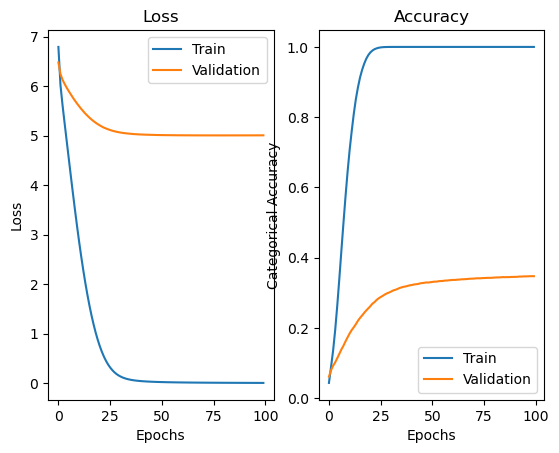

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history6.history["loss"], label="Train")
plt.plot(history6.history["val_loss"], label="Validation")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.plot(history6.history["top_k_categorical_accuracy"], label="Train")
plt.plot(history6.history["val_top_k_categorical_accuracy"], label="Validation")
plt.legend()

In [ ]:
model6.save('modelResnetOversampling20.h5')

Como se puede observar con este optimizer logramos los mejores resultados. Llegamos a un 34.72% de top k accuracy. Además con esta configuración, la pérdida en validación va disminuyendo junto con la de entrenamiento.
Por lo que este es el modelo final.